In [ ]:
import nltk
import collections
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import random
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Preprocessing the documents
1.get rid of the stopword, symbol and numeric character
2.calcuate TF-IDF
3.create tag map
4.lemmazation/stemming(cagatorize the words with different tense)

In [ ]:
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def Preprocssing(filename, L = None):
  # return x_pro: list of list of strings, x_pro is as a list of a sentence
  # and y_pro: list of string, y_pro is the emotion label of sentence corresponding to x_pro
  stop_words = set(stopwords.words("english"))
  stop_words.add("didnt")
  
  with open(filename,"r") as f1:
    ps = PorterStemmer() 
    x_pro = []
    y_pro = []
    for line in f1:
      delim = line.find(';')
      x_raw = line[0:delim]
      y_ = line[delim + 1: -1]
      y_pro.append(y_)
      x_raw = x_raw.lower()
      words = word_tokenize(x_raw) 
      x_stem = []
      for w in words: 
        if w not in stop_words:
          x_stem.append(ps.stem(w))
      if L:
        x_pro.append(' '.join(x_stem))
      else:
        x_pro.append(x_stem)
    f1.close()
  return x_pro, y_pro 

def Preprocssing_TFIDF(filename):
  # return x_pro: list of list of strings, x_pro is as a list of a sentence
  # and y_pro: list of string, y_pro is the emotion label of sentence corresponding to x_pro
  data_raw = pd.read_csv(filename, sep = ";", header = None)
  y_train_raw = [entry.lower() for entry in data_raw[1]]
  data_raw[0] = [entry.lower() for entry in data_raw[0]]
  data_raw[0] = [word_tokenize(entry) for entry in data_raw[0]]

  for index,entry in enumerate(data_raw[0]):
      Final_words = []
      word_Lemmatized = WordNetLemmatizer()
      # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
      for word, tag in pos_tag(entry):
          # Below condition is to check for Stop words and consider only alphabets
          if word not in stopwords.words('english') and word.isalpha():
              word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
              Final_words.append(word_Final)
      # The final processed set of words for each iteration will be stored in 'text_final'
      data_raw.loc[index,'text_final'] = str(Final_words)

  return data_raw["text_final"], data_raw[1]

def HisCount(filename):
  # return x_pro: list of list of strings, x_pro is as a list of a sentence
  # and y_pro: list of string, y_pro is the emotion label of sentence corresponding to x_pro
  data_raw = pd.read_csv(filename, sep = ";", header = None)

  emo_map = {}
  emo_count = {}
  emo_total_set = set()

  for i in range(len(data_raw)):
    x = data_raw[0][i]
    y = data_raw[1][i]
    if y not in emo_total_set:
      emo_total_set.add(y)
      emo_count[y] = 0
      emo_map[y] = 0
    emo_map[y] += 1
    emo_count[y] += len(x)
  
  for key in emo_count.keys():
    emo_count[key] /= emo_map[key]

  return emo_map, emo_count  

In [ ]:
emo_map, emo_count = HisCount("train.txt")
print(emo_map)
print(emo_count)

{'sadness': 4666, 'anger': 2159, 'love': 1304, 'surprise': 572, 'fear': 1937, 'joy': 5362}
{'sadness': 92.55057865409344, 'anger': 96.91153311718388, 'love': 104.03374233128834, 'surprise': 101.67657342657343, 'fear': 96.12390294269488, 'joy': 98.5544572920552}


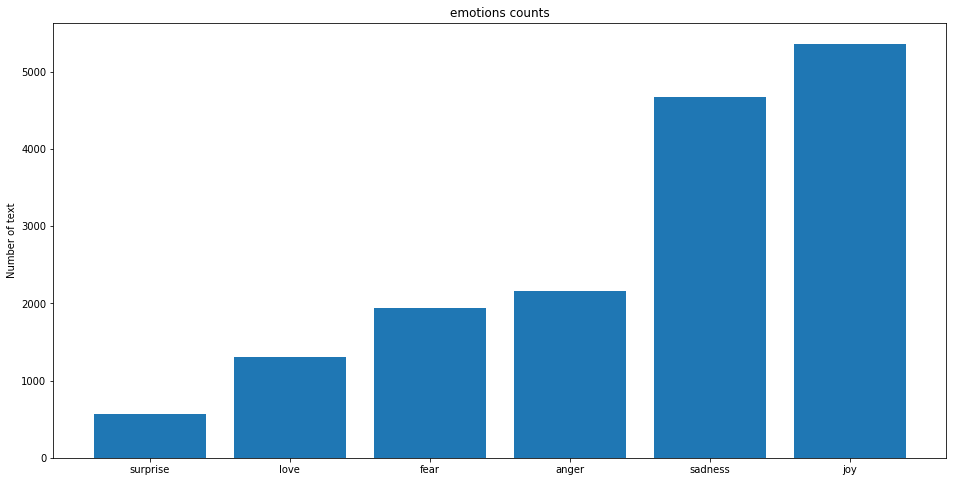

In [ ]:
categories = list(emo_map.keys())
counts = list(emo_map.values())
order = [3,2,4,1,0,5]
categories_re = [0]*6
counts_re = [0]*6
for i in range(6):
  categories_re[i] = categories[order[i]]
  counts_re[i] = counts[order[i]]
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(categories_re, counts_re);
ax.set_xticks(categories_re);
ax.set_ylabel('Number of text');
ax.set_title('emotions counts');
plt.show();

In [ ]:
# import plotly.express as px
# li = []
# li.append(list(emo_count.values()))
# li.append(list(emo_count.keys()))
# df = pd.DataFrame({"cat":list(emo_count.keys()),
#                    "len":list(emo_count.values()),
#                    "pos":[0,2,4,6,8,10]})
# print(df)
# fig = px.scatter(df, x='cat', y='pos', hover_name='cat', text='cat', size='len', size_max=150
#                  , template='plotly_white', title='Bigram similarity and frequency', labels={'words': 'Avg. Length<BR>(words)'}
#                  , color_continuous_scale=px.colors.sequential.Sunsetdark)
# fig.update_traces(marker=dict(line=dict(width=1, color='Gray')))
# fig.update_xaxes(visible=False)
# fig.update_yaxes(visible=False)
# fig.show()

In [ ]:
def confusion(y_test, y_pred, emo): 
  conf_mat = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=emo, yticklabels = emo)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

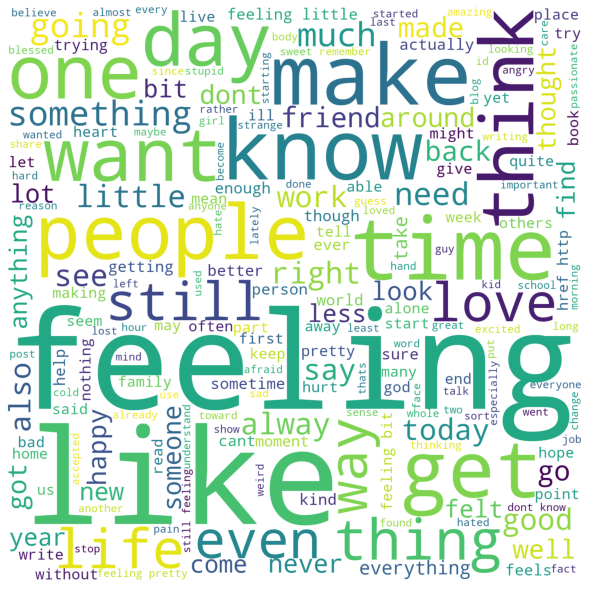

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

stop_words = set(stopwords.words("english"))
stop_words.add("didnt")
stop_words.add("im")
stop_words.add("ive")
stop_words.add("would")
stop_words.add("could")
stop_words.add("really")
stop_words.add("feel")

comment_words = ''
with open("train.txt","r") as f1:
    x_pro = []
    for line in f1:
      delim = line.find(';')
      x_raw = str(line[0:delim])
      x_raw = x_raw.lower()
      tokens = x_raw.split() 
      for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
      comment_words += " ".join(tokens)+" "
    f1.close() 

    
wordcloud = WordCloud(width = 1600, height = 1600, background_color ='white',stopwords = stop_words,  min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
x_train, y_train = Preprocssing("train.txt")
x_val, y_val = Preprocssing("val.txt")
x_test, y_test = Preprocssing("test.txt")

Majority vote
iterate through the whole training document, text by text, to count the appearance of the word and its contribution the emotion corresponding to the text.
Then calculate the emotion score of the test document by summing up the contribution of each word, and the algorithm pick the largest one as the prediction. 

In [ ]:
def Majority_Vote(x_train, y_train):
  # dictionary word -> emotions, word as key, emotion in a set
  emo_map = {}
  emo_total_set = set()
  word_num_appearance = {}
  for i in range(len(x_train)):
    if y_train[i] not in emo_total_set:
      emo_total_set.add(y_train[i])
    for word in x_train[i]:
      if word not in emo_map.keys():
        emo_map[word] = {}
        word_num_appearance[word] = 0
      if y_train[i] not in emo_map[word].keys():
          emo_map[word][y_train[i]] = 0
      emo_map[word][y_train[i]] += 1
      word_num_appearance[word] += 1

  # normalize the model
  for k in emo_map:
    for k2 in emo_map[k]:
      emo_map[k][k2] /= word_num_appearance[k]
  print("number of labels: " + str(len(emo_total_set)))
  return emo_map, emo_total_set

def Predict(model_, x, all_emo):
  pred = [None] * len(x)
  for i in range(len(x)):
    sen_emo = {}
    for word in x[i]:
      if word in model_.keys():
        emo_set = model_[word]
        for emo in emo_set.keys():
          if emo not in sen_emo.keys():
            sen_emo[emo] = 0
          sen_emo[emo] += emo_set[emo]
    # loop through sen_emo find biggest one, ow, random guess
    w = 0
    for emo_g in sen_emo.keys():
      if sen_emo[emo_g] > w:
        w = sen_emo[emo_g]
        pred[i] = emo_g
    
    # if none, 
    if w == 0:
      pred[i] = random.choice(tuple(all_emo))
        
  return pred

In [ ]:
model_MV, all_emo = Majority_Vote(x_train, y_train)
prediction = Predict(model_MV, x_test, all_emo)
train_pred = Predict(model_MV, x_train, all_emo)

number of labels: 6


In [ ]:
def eval_simple(prediction, label):
  FAL = 0
  for i in range(len(prediction)):
    if prediction[i] != label[i]:
      FAL += 1

  return (len(prediction) - FAL) / len(prediction) 

In [ ]:
Test_c, _ = HisCount("test.txt")
print(Test_c)

{'sadness': 581, 'joy': 695, 'fear': 224, 'anger': 275, 'love': 159, 'surprise': 66}


test_acc: 0.632
train_acc: 0.735875


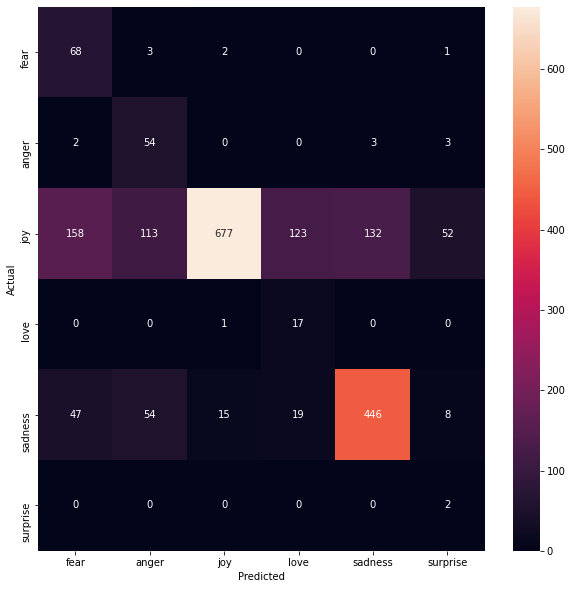

In [ ]:
print("test_acc: " + str(eval_simple(prediction,y_test)))
print("train_acc: " + str(eval_simple(train_pred,y_train)))

la_mv = ["fear","anger", "joy", "love","sadness","surprise"]
confusion(prediction, y_test, la_mv) 

SVM.
calculate the TFIDF(the importance) of the word and unique identification number of the word. 
Padding each text until every text has same length and use TFIDF as its vectorized elements, then do the classification in high dimensional space

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train_svmnb, Y_train_label_svmnb = Preprocssing_TFIDF("train.txt")
X_test_svmnb, Y_test_label_svmnb = Preprocssing_TFIDF("test.txt")

Encoder = LabelEncoder()
y_train_label = Encoder.fit_transform(Y_train_label_svmnb)
y_test_label = Encoder.fit_transform(Y_test_label_svmnb)

Tfidf_vect = TfidfVectorizer(max_features=5000)

Tfidf_vect.fit(X_train_svmnb)
X_train_Tfidf = Tfidf_vect.transform(X_train_svmnb)
X_test_Tfidf = Tfidf_vect.transform(X_test_svmnb)


Naive Bayes.
Assume the positions of the words do not matter and try to use a bag of words in the text to predict its catagory.
calculate the frequencies of the word by TDM (term-document matrix)
maximize the MAP of the probability of catagory given data to estimate the test docuemnt.


In [ ]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_Tfidf,y_train_label)

predictions_NB = Naive.predict(X_test_Tfidf)
predictions_NB_train = Naive.predict(X_train_Tfidf)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test_label)*100)
print("Naive Bayes train Accuracy Score -> ",accuracy_score(predictions_NB_train, y_train_label)*100)


SVM = svm.SVC(C=2.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_Tfidf,y_train_label)

predictions_SVM = SVM.predict(X_test_Tfidf)
predictions_SVM_train = SVM.predict(X_train_Tfidf)

print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test_label)*100)
print("SVM train Accuracy Score -> ",accuracy_score(predictions_SVM_train, y_train_label)*100)


Naive Bayes Accuracy Score ->  73.35000000000001
Naive Bayes train Accuracy Score ->  79.7375
SVM Accuracy Score ->  86.25
SVM train Accuracy Score ->  96.275


In [ ]:
print(Test_c)

{'sadness': 581, 'joy': 695, 'fear': 224, 'anger': 275, 'love': 159, 'surprise': 66}


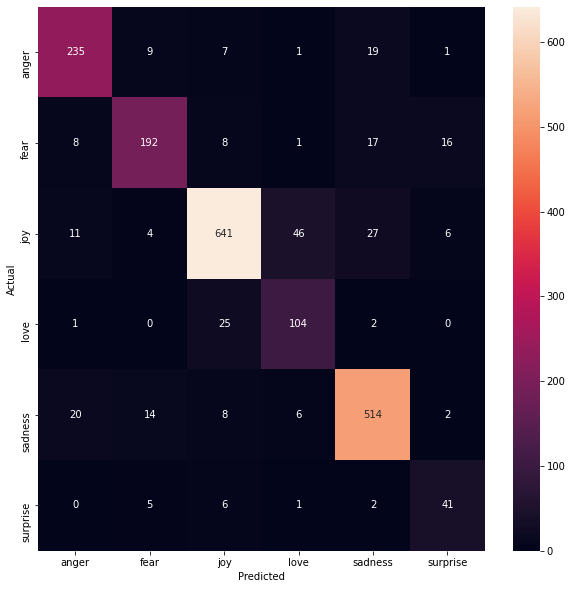

In [ ]:
la_svm = ["anger","fear", "joy", "love","sadness","surprise"]
confusion(predictions_SVM, y_test_label, la_svm)

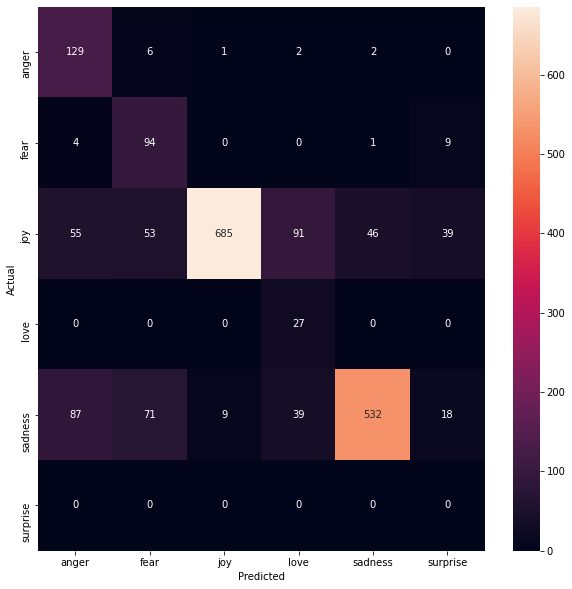

In [ ]:
confusion(predictions_NB, y_test_label, la_svm)

Preprocess the train input as SVM does.
Feed into two layers of LSTM to train the model

In [ ]:
MAX_NB_WORDS = 5000
MAX_LENGTH = 100
EMBEDDING_DIM = 64
oov_tok = '<OOV>'

x_train_lstm, y_train_lstm = Preprocssing("train.txt", "LSTM")
x_val_lstm, y_val_lstm = Preprocssing("val.txt", "LSTM")
x_test_lstm, y_test_lstm = Preprocssing("test.txt", "LSTM")

tokenizer = Tokenizer(num_words = MAX_NB_WORDS, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train_lstm)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train_lstm)
val_sequences = tokenizer.texts_to_sequences(x_val_lstm)

train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM)),

    tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])
model.summary()

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train_lstm)
training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train_lstm))
val_label_seq = np.array(label_tokenizer.texts_to_sequences(y_val_lstm))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10

history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(val_padded, val_label_seq), verbose=2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 455       
Total params: 394,759
Trainable params: 394,759
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
500/500 - 42s - loss: 1.0362 - accuracy: 0.6114 - val_loss: 0.5054 - val_accuracy: 0.8295
Epoch 2/10
500/500 - 40s - loss: 0.3053 - accuracy: 0.8932 - val_loss: 0.3507 - val_accuracy: 0.8770
Epoch 3/10
500/500 - 40s - loss: 0.1589 - ac

In [ ]:
test_sequences = tokenizer.texts_to_sequences(x_test_lstm)

test_padded = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')


test_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test_lstm))

y_pred = model.predict_classes(test_padded)
y_pred_train = model.predict_classes(train_padded)
print("LSTM Accuracy Score -> ",accuracy_score(test_label_seq, y_pred)*100)
print("LSTM train Accuracy Score -> ",accuracy_score(training_label_seq, y_pred_train)*100)

LSTM Accuracy Score ->  87.75
LSTM train Accuracy Score ->  98.6875


In [ ]:
print(Test_c)

{'sadness': 581, 'joy': 695, 'fear': 224, 'anger': 275, 'love': 159, 'surprise': 66}


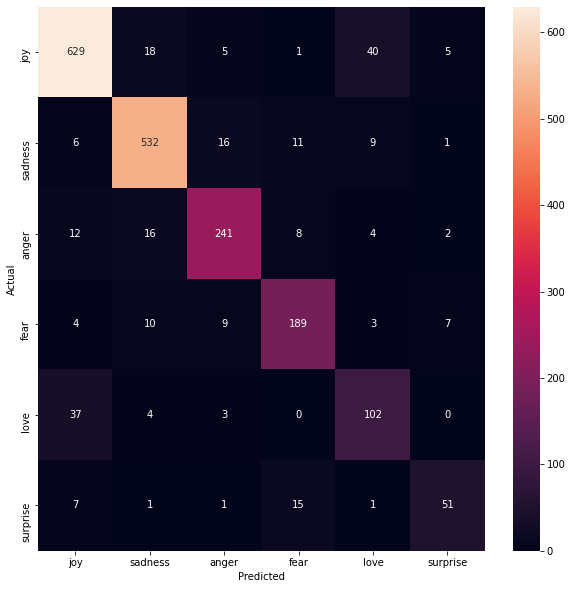

In [ ]:
la_lstm = ["joy","sadness", "anger", "fear","love","surprise"]
confusion(y_pred, test_label_seq, la_lstm) 